### Packed Padded Sequences, Masking, Inference and BLEU

In this notebook we will be adding a few improvements - `packed padded sequences` and `masking` - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP.

We will also look at how to use our model for inference for the first time, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the `BLEU` metric to measure the quality of our translations.

So basically in this notebook we are going to pay a closer look to a practical example.

### Data Preparation
Again we still prepare the data just like from the previous notebooks. We will also import `matplotlib.pyplot` so that we will visualize the attention.

In [1]:
import torch
from torch import nn
from torch.nn  import functional as F
import spacy, math, random
import numpy as np
from torchtext.legacy import datasets, data
import time
from prettytable import PrettyTable
from matplotlib import pyplot as plt

### Setting seeds

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Loading the German and English models.

In [3]:
import spacy
import spacy.cli
spacy.cli.download('de_core_news_sm')

import de_core_news_sm, en_core_web_sm

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


### Preprocessing function that tokenizes sentences.

In [4]:
def tokenize_de(sent):
  return [tok.text for tok in spacy_de.tokenizer(sent)]

def tokenize_en(sent):
  return [tok.text for tok in spacy_en.tokenizer(sent)]

### Creating the `Fields`

**Now**, When using packed padded sequences, we need to tell `PyTorch` how long the actual `(non-padded)` sequences are. Luckily for us, `TorchText`'s Field objects allow us to use the `include_lengths` argument, this will cause our batch.`src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the `non-padded lengths` of each source sentence within the batch.

**Note:** We have only used `include_lengths` arg to `True` on the `SRC`

In [5]:
SRC = data.Field(
    tokenize = tokenize_de,
    lower= True,
    init_token = "<sos>",
     eos_token = "<eos>",
     include_lengths =True
)
TRG = data.Field(
    tokenize = tokenize_en,
    lower= True,
    init_token = "<sos>",
     eos_token = "<eos>"
)

### Loading `Multi30k` dataset.


In [6]:
train_data, valid_data, test_data = datasets.Multi30k.splits(
    exts=('.de', '.en'),
    fields = (SRC, TRG)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.15MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 165kB/s]


### Checking if we have loaded the data corectly.

In [7]:
from prettytable import PrettyTable
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  table.title= "VISUALIZING SETS EXAMPLES"
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

column_names = ["SUBSET", "EXAMPLE(s)"]
row_data = [
        ["training", len(train_data)],
        ['validation', len(valid_data)],
        ['test', len(test_data)]
]
tabulate(column_names, row_data)

+-----------------------------+
|  VISUALIZING SETS EXAMPLES  |
+--------------+--------------+
| SUBSET       |   EXAMPLE(s) |
+--------------+--------------+
| training     |        29000 |
| validation   |         1014 |
| test         |         1000 |
+--------------+--------------+


### Checking a single example, of the `SRC` and the `TRG`.

In [8]:
print(vars(train_data[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### Building the vocabulary.
Just like from the previous notebook all the tokens that apears less than 2, are automatically converted to unknown token `<unk>`.

In [9]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

### Device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating Iterators.

One quirk about packed padded sequences is that all elements in the batch need to be **sorted** by their `non-padded` lengths in descending order, i.e. the first sentence in the batch needs to be the longest. 

We use two arguments of the iterator to handle this, `sort_within_batch` which tells the iterator that the contents of the batch need to be sorted, and `sort_key` a function which tells the iterator how to sort the elements in the batch. Here, we sort by the length of the src sentence.


In [29]:
BATCH_SIZE = 128
sort_key = lambda x: len(x.src)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key= sort_key,
    sort_within_batch = True
)

### Encoder.

**The changes here all within the forward method. It now accepts the lengths of the source sentences as well as the sentences themselves.**


After the source sentence (padded automatically within the iterator) has been embedded, we can then use pack_padded_sequence on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a `CPU` tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and hidden which is simply the final hidden state from our sequence. hidden is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final `non-padded` element in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the outputs and the lengths of each, which we don't need.

The first dimension of outputs is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [12]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_dim, embedding_dim=emb_dim)
    self.gru = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src, src_len):
    """ 
    src = [src len, batch size]
    src_len = [batch size]
    """
    embedded = self.dropout(self.embedding(src)) # embedded = [src len, batch size, emb dim]
    # need to explicitly put lengths on cpu!
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
    packed_outputs, hidden = self.gru(packed_embedded)
    """
    packed_outputs is a packed sequence containing all hidden states
    hidden is now from the final non-padded element in the batch
    """
    outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
    """
    outputs is now a non-packed sequence, all hidden states obtained
    when the input is a pad token are all zeros
  
    outputs = [src len, batch size, hid dim * num directions]
    hidden = [n layers * num directions, batch size, hid dim]

    hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
    outputs are always from the last layer

    hidden [-2, :, : ] is the last of the forwards RNN 
    hidden [-1, :, : ] is the last of the backwards RNN

    initial decoder hidden is final hidden state of the forwards and backwards 
    encoder RNNs fed through a linear layer
    """
    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

    """
    outputs = [src len, batch size, enc hid dim * 2]
    hidden = [batch size, dec hid dim]
    """
    return outputs, hidden


### Attention Layer

The attention module is where we calculate the attention values over the source sentence.

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.

The forward method now takes a mask input. This is a **[batch size, source sentence length]** tensor that is `1` when the source sentence token is not a padding token, and `0` when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", <pad>, <pad>]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the softmax function. It is applied using `masked_fill`. **This fills the tensor at each element where the first argument `(mask == 0)` is true, with the value given by the second argument (-1e10).** In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the softmax layer, ensuring no attention is payed to padding tokens in the source sentence.

In [13]:
class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super(Attention, self).__init__()
    self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim, 1, bias = False)

  def forward(self, hidden, encoder_outputs, mask):
    """
    hidden = [batch size, dec hid dim]
    encoder_outputs = [src len, batch size, enc hid dim * 2]
    """
    batch_size = encoder_outputs.shape[1]
    src_len = encoder_outputs.shape[0]
    # repeat decoder hidden state src_len times
    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
    encoder_outputs = encoder_outputs.permute(1, 0, 2)

    """
    hidden = [batch size, src len, dec hid dim]
    encoder_outputs = [batch size, src len, enc hid dim * 2]
    """
    energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) # energy = [batch size, src len, dec hid dim]
    attention = self.v(energy).squeeze(2) # attention= [batch size, src len]
    attention = attention.masked_fill(mask == 0, -1e10)
    return F.softmax(attention, dim=1)
    

### Decoder.

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [51]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super(Decoder, self).__init__()
    self.output_dim = output_dim
    self.attention = attention

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.fc = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, input, hidden, encoder_outputs, mask):
    """
    input = [batch size]
    hidden = [batch size, dec hid dim]
    encoder_outputs = [src len, batch size, enc hid dim * 2]
    mask = [batch size, src len]
    """
    input = input.unsqueeze(0) # input = [1, batch size]
    embedded = self.dropout(self.embedding(input)) # embedded = [1, batch size, emb dim]
    a = self.attention(hidden, encoder_outputs, mask)# a = [batch size, src len]
    a = a.unsqueeze(1) # a = [batch size, 1, src len]
    encoder_outputs = encoder_outputs.permute(1, 0, 2) # encoder_outputs = [batch size, src len, enc hid dim * 2]
    weighted = torch.bmm(a, encoder_outputs) # weighted = [batch size, 1, enc hid dim * 2]
    weighted = weighted.permute(1, 0, 2) # weighted = [1, batch size, enc hid dim * 2]
    rnn_input = torch.cat((embedded, weighted), dim = 2) # rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
    output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
    
    """
    output = [seq len, batch size, dec hid dim * n directions]
    hidden = [n layers * n directions, batch size, dec hid dim]
    
    seq len, n layers and n directions will always be 1 in this decoder, therefore:
    output = [1, batch size, dec hid dim]
    hidden = [1, batch size, dec hid dim]
    this also means that output == hidden
    """
    assert (output == hidden).all()
    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)

    prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1)) # prediction = [batch size, output dim]
    return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq Model

The overarching `seq2seq` model also needs a few changes for packed padded sequences, masking and inference.

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the forward method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each `time-step` is stored in the attentions

In [61]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    self.src_pad_idx = src_pad_idx
  
  def create_mask(self, src):
    mask = (src != self.src_pad_idx).permute(1, 0)
    return mask
  def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
    """
    src = [src len, batch size]
    src_len = [batch size]
    trg = [trg len, batch size]
    teacher_forcing_ratio is probability to use teacher forcing
    e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
    """
    trg_len, batch_size = trg.shape
    trg_vocab_size = self.decoder.output_dim
        
    # tensor to store decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    """
    encoder_outputs is all hidden states of the input sequence, back and forwards
    hidden is the final forward and backward hidden states, passed through a linear layer
    """
    encoder_outputs, hidden = self.encoder(src, src_len)     
    # first input to the decoder is the <sos> tokens
    input = trg[0,:]
    mask = self.create_mask(src) # mask = [batch size, src len]
    for t in range(1, trg_len):
      # insert input token embedding, previous hidden state and all encoder hidden states and mask
      # receive output tensor (predictions) and new hidden state
      output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
      
      # place predictions in a tensor holding predictions for each token
      outputs[t] = output
      
      # decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio
      
      # get the highest predicted token from our predictions
      top1 = output.argmax(1) 
      
      # if teacher forcing, use actual next token as next input
      # if not, use predicted token
      input = trg[t] if teacher_force else top1
    return outputs

### Training the Seq2Seq Model

The rest of the code is similar from the previous notebooks, where there's changes I will highlight.

### Hyper parameters

In [62]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = DEC_EMB_DIM = 256
ENC_HID_DIM = DEC_HID_DIM = 512
ENC_DROPOUT = DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Initializing the weights
ere, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [63]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
        nn.init.normal_(param.data, mean=0, std=0.01)
    else:
        nn.init.constant_(param.data, 0)   
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Counting model parameters.


In [64]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 20,518,917
Total tainable parameters: 20,518,917


### Optimizer

In [65]:
optimizer = torch.optim.Adam(model.parameters())

### Loss Function
Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.



In [66]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training and Evaluating Functions

As we are using include_lengths = True for our source field, batch.src is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.


In [70]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        """
        trg = [trg len, batch size]
        output = [trg len, batch size, output dim]
        """
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        """
        trg = [(trg len - 1) * batch size]
        output = [(trg len - 1) * batch size, output dim]
        """
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
      for i, batch in enumerate(iterator):
          src, src_len = batch.src
          trg = batch.trg
          optimizer.zero_grad()
          output = model(src, src_len, trg, 0) ## Turn off the teacher forcing ratio.
          """
          trg = [trg len, batch size]
          output = [trg len, batch size, output dim]
          """
          output_dim = output.shape[-1]
          output = output[1:].view(-1, output_dim)
          trg = trg[1:].view(-1)
          """
          trg = [(trg len - 1) * batch size]
          output = [(trg len - 1) * batch size, output dim]
          """
          loss =  criterion(output, trg)
          epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Train Loop.

Bellow is a function that tells us how long each epoch took to complete.

In [71]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [72]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'best-model.pt')
  
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 47s
	Train Loss: 4.140 | Train PPL:  62.773
	 Val. Loss: 4.181 |  Val. PPL:  65.411
Epoch: 02 | Time: 0m 46s
	Train Loss: 3.348 | Train PPL:  28.460
	 Val. Loss: 3.651 |  Val. PPL:  38.503
Epoch: 03 | Time: 0m 47s
	Train Loss: 2.857 | Train PPL:  17.416
	 Val. Loss: 3.379 |  Val. PPL:  29.330
Epoch: 04 | Time: 0m 47s
	Train Loss: 2.446 | Train PPL:  11.544
	 Val. Loss: 3.290 |  Val. PPL:  26.851
Epoch: 05 | Time: 0m 47s
	Train Loss: 2.168 | Train PPL:   8.741
	 Val. Loss: 3.210 |  Val. PPL:  24.784
Epoch: 06 | Time: 0m 47s
	Train Loss: 1.938 | Train PPL:   6.943
	 Val. Loss: 3.178 |  Val. PPL:  24.010
Epoch: 07 | Time: 0m 46s
	Train Loss: 1.743 | Train PPL:   5.714
	 Val. Loss: 3.223 |  Val. PPL:  25.107
Epoch: 08 | Time: 0m 47s
	Train Loss: 1.573 | Train PPL:   4.819
	 Val. Loss: 3.295 |  Val. PPL:  26.982
Epoch: 09 | Time: 0m 47s
	Train Loss: 1.445 | Train PPL:   4.240
	 Val. Loss: 3.358 |  Val. PPL:  28.733
Epoch: 10 | Time: 0m 47s
	Train Loss: 1.366 | Train PPL

### Evaluating the best model.

In [73]:
model.load_state_dict(torch.load('best-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.213 | Test PPL:  24.843 |


### Model inference.

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of `1000` and train for **`4 days`**😭😭!

They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` function will do the following:

* ensure our model is in evaluation mode, which it should always be for inference
* tokenize the source sentence if it has not been tokenized (is a string)
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* get the length of the source sentence and convert to a tensor
* feed the source sentence into the encoder
* create the mask for the source sentence
* create a list to hold the output sentence, initialized with an `<sos>` token
* create a tensor to hold the attention values
* while we have not hit a maximum length
  * get the input tensor, which should be either `<sos>` or the last predicted token
  * feed the input, all encoder outputs, hidden state and mask into the decoder
  * store attention values
  * get the predicted next token
  * add prediction to current output sentence prediction
  * break if the prediction was an `<eos>` token
* convert the output sentence from indexes to tokens
* return the output sentence (with the `<sos>` token removed) and the attention values over the sequence.

In [82]:
import spacy
import de_core_news_sm
def translate_sentence(sent, src_field, trg_field, mdoel, device, max_len=50):
  model.eval()

  if isinstance(sent, str):
    nlp = de_core_news_sm.load()
    tokens = [token.text.lower() for token in nlp(sent)]
  else:
    tokens = [token.lower() for token in sent]
  
  tokens = [src_field.init_token] + tokens + [src_field.eos_token]
  src_indexes = [src_field.vocab.stoi[token] for token in tokens]
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
  src_len = torch.LongTensor([len(src_indexes)])

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

  mask = model.create_mask(src_tensor)
  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
  attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

  for i in range(max_len):
    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    with torch.no_grad():
      output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

    attentions[i] = attention
    pred_token = output.argmax(1).item()
    trg_indexes.append(pred_token)

    if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
       break
  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
  return trg_tokens[1:], attentions[:len(trg_tokens)-1]


Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [90]:
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the example_idx value to look at different examples.

First, we'll get a source and target from our dataset.

In [91]:
example_idx = 0

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
trg = ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the `x-axis` and the predicted translation on the `y-axis`. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate.

In [92]:
tokens, attention = translate_sentence(src,  SRC, TRG, model, device)
print(tokens)
tokens, attention = translate_sentence("zwei junge",  SRC, TRG, model, device)
print(tokens)

['two', 'young', 'white', 'men', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
['two', 'young', 'lovers', '.', '<eos>']


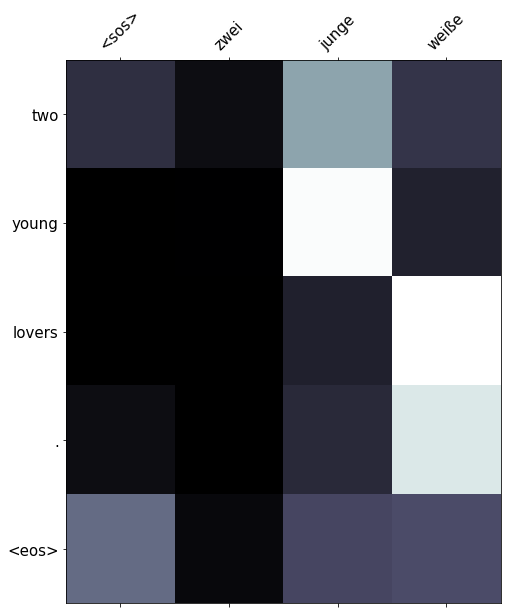

In [93]:
display_attention(src, tokens, attention)

In [95]:

example_idx = 14
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'plays', 'a', 'song', 'on', 'her', 'violin', '.', '<eos>']


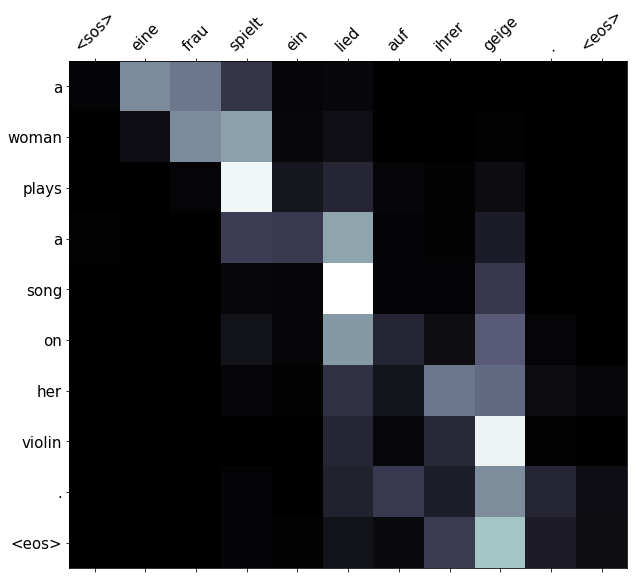

In [96]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

> The model misses `plays` to `playing`.

### Examples in the test set.

In [98]:
example_idx = 18
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'a', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


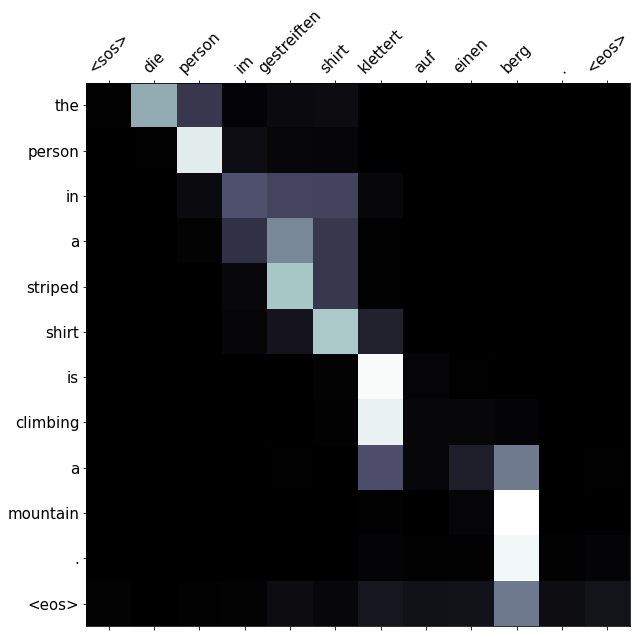

In [99]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

###  Let's translate more examples from the test set.

In [116]:
def tabulate_translations(column_names, data, title, max_characters=25):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'l'
  table.align[column_names[2]] = 'l'
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters, column_names[2]:max_characters}
  for row in data:
    table.add_row(row)
  print(table)
columns_names = [
    "German (real src sentence)", "English (the actual text)", "Translated (translated version)"
]
title = "GERMAN to ENGLISH TRANSLATOR"

def translation_table(src, SRC, TRG, model, device,columns_names, title,  max_characters=25,total_translations=10):
  rows_data = []
  for idx in range(total_translations):
    src = vars(test_data.examples[idx])['src']
    trg = vars(test_data.examples[idx])['trg']
    trasl, _ = translate_sentence(src, SRC, TRG, model, device)
    rows_data.append(
        [
        " ".join(src),
        " ".join(trg),
        " ".join(trasl).replace('<eos>', '')
        ], 
    )
    if idx+1 != total_translations:
      rows_data.append(["-" * max_characters, "-" * max_characters, "-" * max_characters ])

  tabulate_translations(columns_names, rows_data, title, max_characters)
translation_table(src, SRC, TRG, model, device,columns_names, title, max_characters=36)

+--------------------------------------------------------------------------------------------------------------------+
|                                            GERMAN to ENGLISH TRANSLATOR                                            |
+--------------------------------------+--------------------------------------+--------------------------------------+
| German (real src sentence)           | English (the actual text)            | Translated (translated version)      |
+--------------------------------------+--------------------------------------+--------------------------------------+
| ein mann mit einem orangefarbenen    | a man in an orange hat starring at   | a man in an orange hat is something  |
| hut , der etwas anstarrt .           | something .                          | something .                          |
| ------------------------------------ | ------------------------------------ | ------------------------------------ |
| ein boston terrier läuft über        | a bosto

### BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is BLEU. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between `0` and `1` for each sequence, where `1` means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a calculate_bleu function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [117]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        # cut off <eos> token
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    return bleu_score(pred_trgs, trgs)


We get a BLEU of around `31.15`. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of `26.75`. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the higher **BLEU score is "better"**.

In [118]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.15



In the next notebook we will be moving away from using recurrent neural networks and start looking at other ways to construct `sequence-to-sequence` models. Specifically, in the next notebook we will be using convolutional neural networks.

### Credits.
* [bentrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)